In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.datasets import cifar10
from keras.utils import to_categorical

from keras.layers import Layer, Input, Dense, Conv2D, MaxPooling2D, Flatten, MultiHeadAttention, Add, Lambda
from keras.models import Model, Sequential

import matplotlib.pyplot as plt
import random


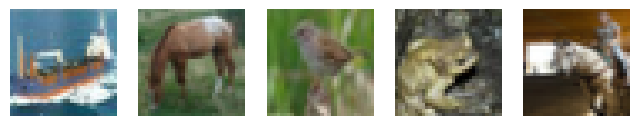

In [2]:
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
xTrain, xTest = xTrain / 255.0, xTest / 255.0
yTrain, yTest = to_categorical(yTrain), to_categorical(yTest)

_, boxes = plt.subplots(1, 5, figsize=(8, 8))

for box in boxes:
    index = random.randint(0, len(xTrain))
    box.imshow(xTrain[index])
    box.axis('off')

In [3]:
def FilterHeap(ch=8):
    return Sequential(
        [
            Input(shape=(32, 32, 3)),
            Conv2D(ch, 3, activation="relu"),
            MaxPooling2D(2),
            Conv2D(ch, 3, activation="relu"),
            MaxPooling2D(2),
            Conv2D(ch, 3, activation="relu"),
            Flatten(),
            Dense(10, activation="softmax"),
        ]
    )


def GetActivations(model, inputs):
    activations = []
    for layer in model.layers:
        inputs = layer(inputs)
        activations.append(tf.reshape(inputs, [inputs.shape[0], -1]))
    activations = tf.concat(activations, axis=1)
    return activations


def SampleSequence(activations, indices):
    sequence = tf.concat([
        tf.one_hot(indices, activations.shape[1]),
        tf.expand_dims(tf.gather(activations, indices, axis=1, batch_dims=1), axis=2)
    ], axis=2)
    return sequence



In [4]:

class TransformerBlock(Layer):
    def __init__(self, embed, heads, expand):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=heads, key_dim=embed)
        self.ffn = Sequential(
            [layers.Dense(expand, activation="relu"), layers.Dense(embed)]
        )
        self.add = layers.Add()

    def call(self, inputs): 
        att_out = self.att(inputs, inputs)
        res_out = self.add([inputs, att_out])
        ffn_out = self.ffn(res_out)
        return self.add([res_out, ffn_out])


class TransformerModel(Model):
    def __init__(self, layers=16, embed=128, heads=4, expand=256, classes=10, activations=10906):
        super().__init__()

        self.embedder = Sequential(
            [
                Dense(expand, activation="relu"),
                Dense(embed, activation="relu"),
            ]
        )

        self.class_token = self.add_weight(shape=(1, 1, embed), initializer="zeros", trainable=True)
        self.policy_token = self.add_weight(shape=(1, 1, embed), initializer="zeros", trainable=True)

        self.blocks = []
        for _ in range(layers):
            self.blocks.append(TransformerBlock(embed, heads, expand))


        self.classification_head = Sequential(
            [
                Dense(expand, activation="relu"),
                Dense(expand, activation="relu"),
                Dense(classes, activation="softmax"),
            ]
        )
        self.policy_head = Sequential(
            [
                Dense(expand, activation="relu"),
                Dense(expand, activation="relu"),
                Dense(activations, activation="softmax"),
            ]
        )

    def call(self, inputs):
        x = self.embedder(inputs)
        # prepend the class and policy tokens to the embedded sequence, duplicating for the batch
        x = tf.concat([tf.tile(self.class_token, [tf.shape(x)[0], 1, 1]), x], axis=1)
        x = tf.concat([tf.tile(self.policy_token, [tf.shape(x)[0], 1, 1]), x], axis=1)
        for block in self.blocks:
            x = block(x)
        # pass the class token to the classification head, and the policy token to the policy head
        return self.classification_head(x[:, 0]), self.policy_head(x[:, 1])


vision = FilterHeap(8)

vision.compile(optimizer='adam',
                loss='categorical_crossentropy',
              metrics=['accuracy'])

vision.fit(xTrain, yTrain, epochs=10, batch_size=4000, validation_data=(xTest, yTest))



Metal device set to: Apple M2 Max

systemMemory: 96.00 GB
maxCacheSize: 36.00 GB



2023-04-25 09:01:28.474169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-25 09:01:28.474321: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-04-25 09:01:28.953891: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-25 09:01:29.126687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 51ms/step - loss: 2.2982 - accuracy: 0.1181 - val_loss: 2.2856 - val_accuracy: 0.1283
Epoch 2/10
 3/13 [=====>........................] - ETA: 0s - loss: 2.2827 - accuracy: 0.1331

2023-04-25 09:01:29.855804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 32ms/step - loss: 2.2697 - accuracy: 0.1442 - val_loss: 2.2411 - val_accuracy: 0.1500
Epoch 3/10
13/13 [==============================] - 0s 30ms/step - loss: 2.2010 - accuracy: 0.1772 - val_loss: 2.1443 - val_accuracy: 0.2231
Epoch 4/10
13/13 [==============================] - 0s 29ms/step - loss: 2.0959 - accuracy: 0.2342 - val_loss: 2.0438 - val_accuracy: 0.2528
Epoch 5/10
13/13 [==============================] - 0s 29ms/step - loss: 2.0156 - accuracy: 0.2566 - val_loss: 1.9873 - val_accuracy: 0.2795
Epoch 6/10
13/13 [==============================] - 0s 29ms/step - loss: 1.9597 - accuracy: 0.2773 - val_loss: 1.9347 - val_accuracy: 0.2891
Epoch 7/10
13/13 [==============================] - 0s 29ms/step - loss: 1.9077 - accuracy: 0.2970 - val_loss: 1.8860 - val_accuracy: 0.3102
Epoch 8/10
13/13 [==============================] - 0s 29ms/step - loss: 1.8565 - accuracy: 0.3209 - val_loss: 1.8400 - val_accuracy: 0.3330
Epoch 9/10
13/13 [======

In [5]:
learner = TransformerModel(embed=32, expand=64)

learner.compile(optimizer='adam',
            # loss should only apply to the classification head for now, two outputs are returned though
            loss=[keras.losses.CategoricalCrossentropy(), None],
              metrics=['accuracy', None])


seq_len = 16
trainN = 20000
testN = 500

sequence_train = SampleSequence(
        GetActivations(vision, xTrain[:trainN]),
        tf.random.uniform([trainN, seq_len], maxval=10906, dtype=tf.int32)
    )

sequence_test = SampleSequence(
        GetActivations(vision, xTest[:testN]),
        tf.random.uniform([testN, seq_len], maxval=10906, dtype=tf.int32)
    )

learner.fit(sequence_train, yTrain[:trainN], epochs=10, batch_size=1000, validation_data=(sequence_test, yTest[:testN]))

Epoch 1/10


2023-04-25 09:01:42.978856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 4.8587 - output_1_loss: 4.8587 - output_1_accuracy: 0.0988 - output_2_accuracy: 0.0039

2023-04-25 09:03:37.404194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 118s 6s/step - loss: 4.8587 - output_1_loss: 4.8587 - output_1_accuracy: 0.0988 - output_2_accuracy: 0.0039 - val_loss: 2.5262 - val_output_1_loss: 2.5262 - val_output_1_accuracy: 0.1140 - val_output_2_accuracy: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 111s 6s/step - loss: 2.3868 - output_1_loss: 2.3868 - output_1_accuracy: 0.0994 - output_2_accuracy: 0.0000e+00 - val_loss: 2.3082 - val_output_1_loss: 2.3082 - val_output_1_accuracy: 0.1040 - val_output_2_accuracy: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 112s 6s/step - loss: 2.3062 - output_1_loss: 2.3062 - output_1_accuracy: 0.1035 - output_2_accuracy: 0.0000e+00 - val_loss: 2.3005 - val_output_1_loss: 2.3005 - val_output_1_accuracy: 0.1140 - val_output_2_accuracy: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 108s 5s/step - loss: 2.2988 - output_1_loss: 2.2988 - output_1_accuracy: 0.1057 - output_2_accuracy: 0.0000e+00 - val_loss: 2.